# MTH 353_Final Project_Prototype

**This version is a preliminary model with 0.8 accuracy**


# Setup

Below imports the packages we will use to train the model

In [ ]:
# IMPORT NECESSARY LIBRARIES

import numpy as np
import keras
from keras.models import Sequential

# The Sequential class is a linear stack of layers. We use it to build the neural network.
# Each layer has 1 input and 1 output tensor.
# The layers are connected sequentially, and data flows in the order they are added to the model
# Sequential layers automatically adjust the shape of a layer's input based on the output of the layer before it

import tensorflow as tf
from keras import layers
from keras.layers import Dense, Flatten, Dropout

# keras.models contains big picture information about the structure of a network,
# whereas keras.layers contains information about specific layers used in the model.

# The Dense layer is fundemental in building a network with Keras. It means every layer is connected to the one before and after it.
# The Flatten layer is used to convert multidimension data to 1D.
# The Dropout layer is used to avoid overfitting of the network. The dropout rate is a hyperparameter

import matplotlib.pyplot as plt
%matplotlib inline
# makes plot appear without plt.show

from sklearn.metrics import confusion_matrix
import seaborn as sns

np.random.seed(0) #constant results everytime, don't change because of the randomness


# Data Loading

**Upload the images in its category folder**


Reference: https://keras.io/examples/vision/image_classification_from_scratch/




In [ ]:
!unzip ./'Image_Data.zip'

Archive:  ./Image_Data.zip
replace Image Data/greek pottery/terracotta-neck-amphora-jar-530.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Image Data/greek pottery/terracotta-neck-amphora-jar-530.jpg  
  inflating: Image Data/greek pottery/3.jpg  
  inflating: Image Data/greek pottery/attic-geometric-trefoil-mouth-oinochoe-from-athens-725.jpg  
  inflating: Image Data/greek pottery/terracotta-amphora-jar-530.jpg  
  inflating: Image Data/greek pottery/terracotta-kylix-eye-cup-drinking-cup-530.jpg  
  inflating: Image Data/greek pottery/hirschfeld-krater-735.jpg  
  inflating: Image Data/greek/ancient-mieza-macedonian-tombs-of-lefkadia-tomb-of-lyson-and-kallikles-3.jpg  
  inflating: Image Data/greek pottery/1-2.jpg  
  inflating: Image Data/greek pottery/2.jpg  
  inflating: Image Data/greek/tomb-of-the-diver-in-paestum-italy-470.jpg  
  inflating: Image Data/greek pottery/1.jpg  
  inflating: Image Data/greek pottery/bronze-oinochoe-550.jpg  
  inflating: Image Data/greek p

Check Folder

In [ ]:
!ls 'Image Data'

 Egyptian   greek  'greek pottery'  'Greek _ Roman'


Generate Dataset

In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    'Image Data',
    validation_split=0.2,
    subset="both",
    seed=2023,
    image_size=image_size,
    batch_size=batch_size,
)

Found 155 files belonging to 4 classes.
Using 124 files for training.
Using 31 files for validation.


Plot Dataset

In [ ]:
class_names = train_ds.class_names

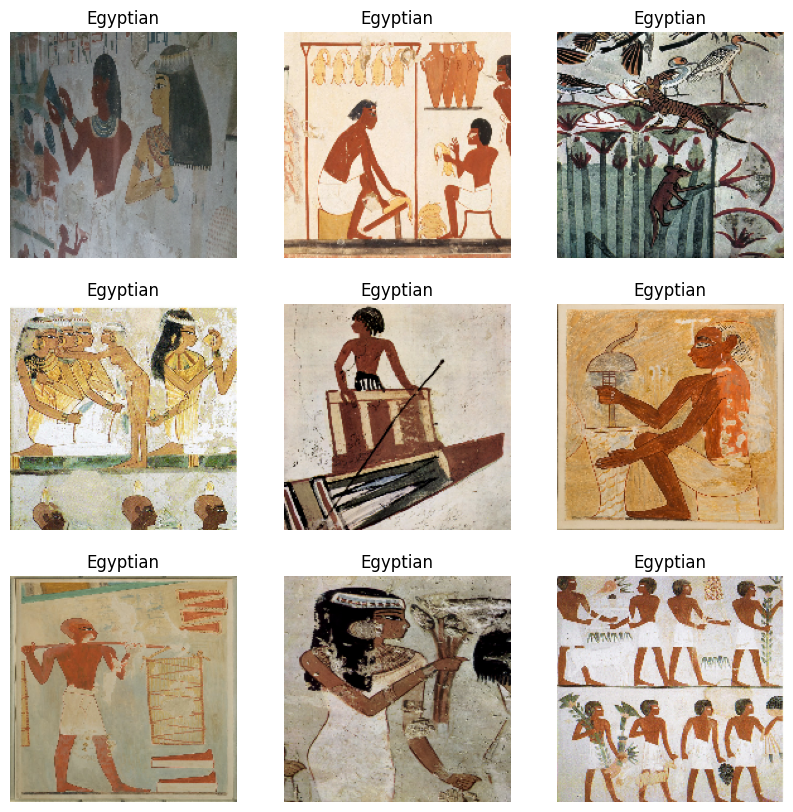

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Data Preprocessing

Image Augmentation

This step is to artificially introduce sample diversity by applying random yet realistic transformations to the training images

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

Visualize

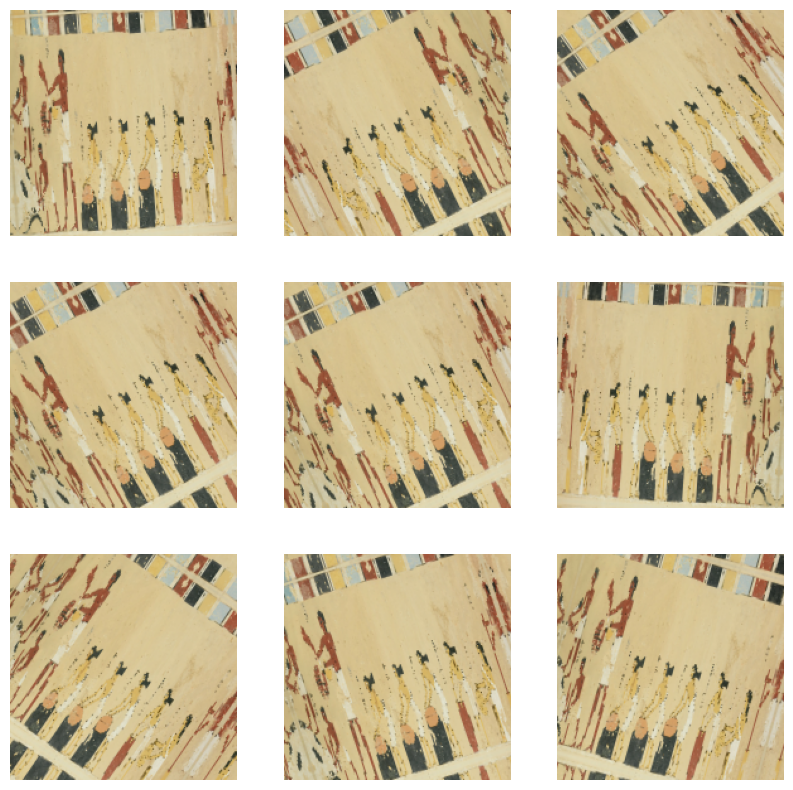

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

Preprocess the Data

In [ ]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x), y))

Configure the dataset for performance (Included step from tutorial)

Apply data augmentation to the training dataset. Use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [ ]:
# # Apply `data_augmentation` to the training images.
# train_ds = train_ds.map(
#     lambda img, label: (data_augmentation(img), label),
#     num_parallel_calls=tf_data.AUTOTUNE,
# )
# # Prefetching samples in GPU memory helps maximize GPU utilization.
# train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
# val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

# Model Setup

Build the model

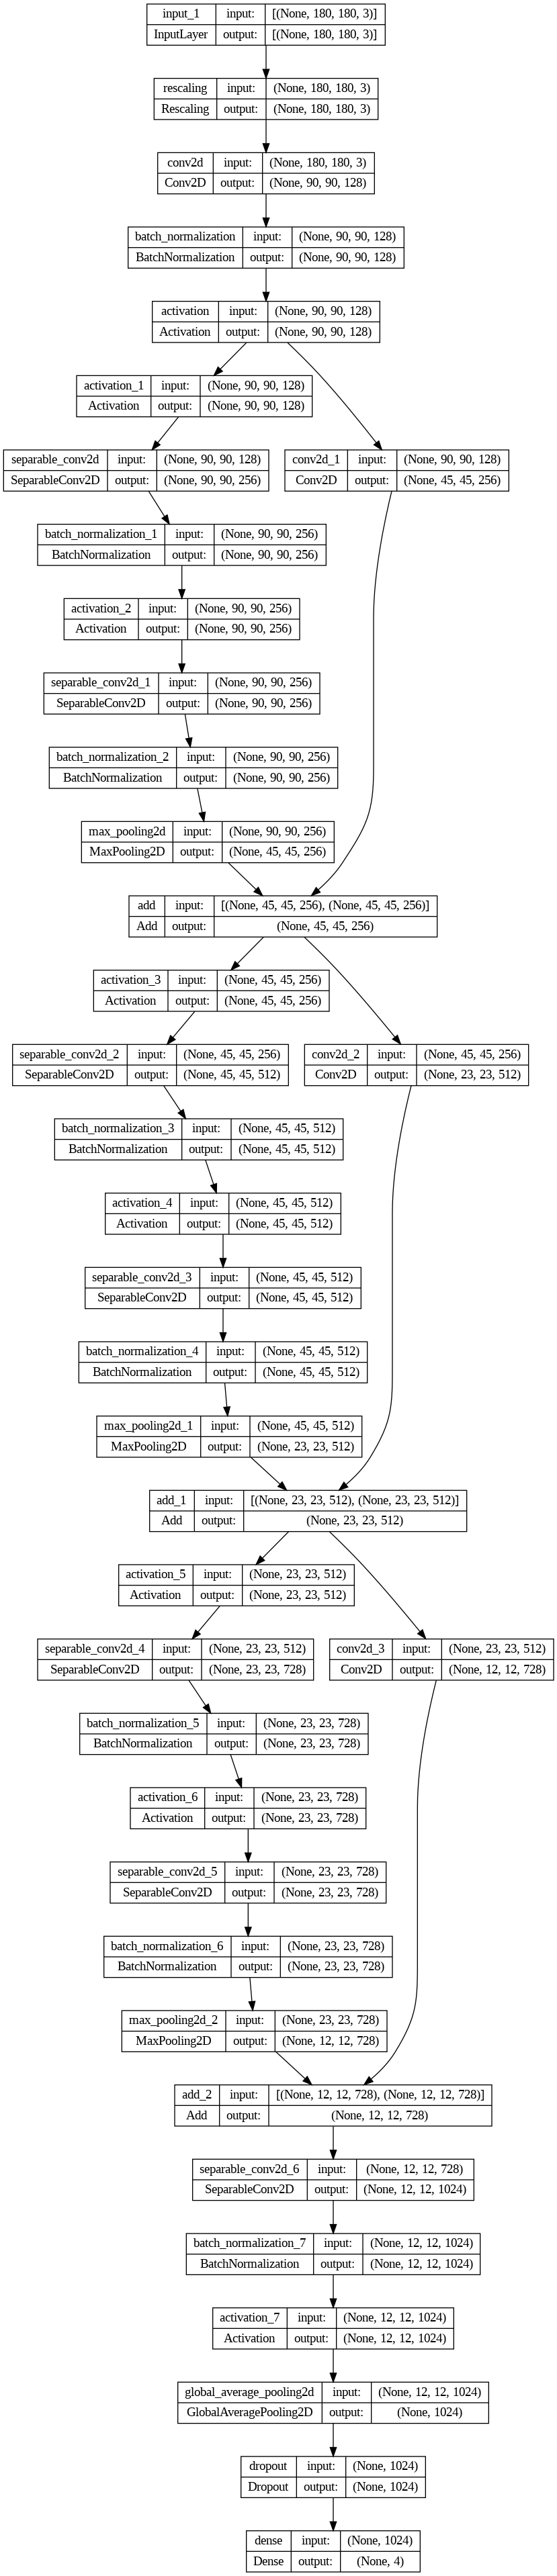

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(num_classes=4,input_shape=image_size+(3,))
keras.utils.plot_model(model, show_shapes=True)

Try a 2nd moedel

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(180, 180, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the 2nd model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model Training



Train the model

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


ValueError: ignored

Train the 2nd model

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1/1 [==============================] - 13s 13s/step - loss: 1.4054 - accuracy: 0.1613 - val_loss: 2.5429 - val_accuracy: 0.6452
Epoch 2/10
1/1 [==============================] - 20s 20s/step - loss: 2.0598 - accuracy: 0.6613 - val_loss: 1.1985 - val_accuracy: 0.6452
Epoch 3/10
1/1 [==============================] - 10s 10s/step - loss: 1.0190 - accuracy: 0.6613 - val_loss: 1.0984 - val_accuracy: 0.3226
Epoch 4/10
1/1 [==============================] - 11s 11s/step - loss: 1.1063 - accuracy: 0.4435 - val_loss: 1.0280 - val_accuracy: 0.7097
Epoch 5/10
1/1 [==============================] - 10s 10s/step - loss: 1.0349 - accuracy: 0.7984 - val_loss: 0.9177 - val_accuracy: 0.6452
Epoch 6/10
1/1 [==============================] - 10s 10s/step - loss: 0.8605 - accuracy: 0.7097 - val_loss: 0.8891 - val_accuracy: 0.6452
Epoch 7/10
1/1 [==============================] - 8s 8s/step - loss: 0.7664 - accuracy: 0.6855 - val_loss: 0.9227 - val_accuracy: 0.6774
Epoch 8/10
1/1 [=============

Visualize Loss & Accuracy

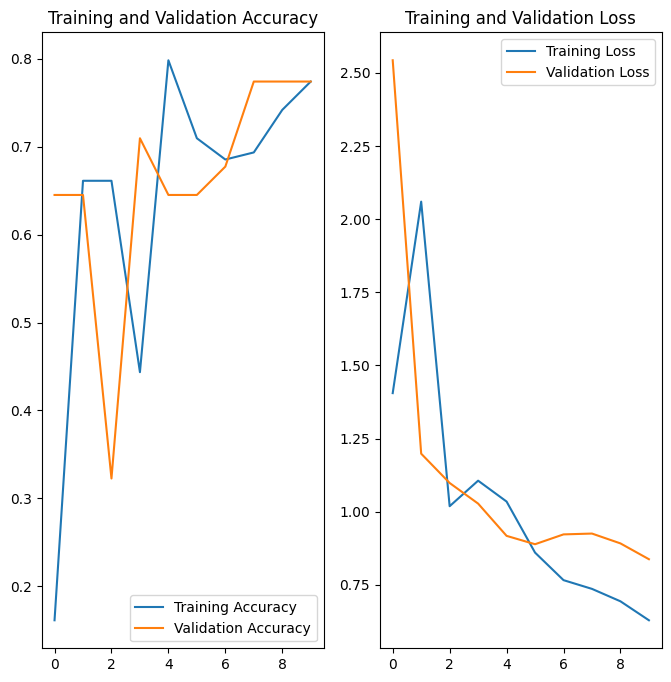

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model Evaluation

Predict on new data

In [ ]:
path = 'ancient-greece-banner-classical-medieval-260nw-1836861451.png'

img = tf.keras.utils.load_img(
  path, target_size=(180, 180)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# print(predictions)

1/1 [==============================] - 0s 52ms/step
This image most likely belongs to Egyptian with a 72.56 percent confidence.


# Confusion Matrix

Create a confusion matrix to visualize the overall result

In [ ]:
y_predictions = model.predict(val_ds)
y_pred_class = [np.argmax(tf.nn.softmax(y_prediction)) for y_prediction in y_predictions]
y_true = np.concatenate([y for x, y in val_ds], axis=0)

print(y_true)

1/1 [==============================] - 2s 2s/step
[0 3 3 0 0 0 0 2 2 0 0 3 2 2 0 0 0 2 0 0 3 0 0 3 0 0 0 2 0 0 0]


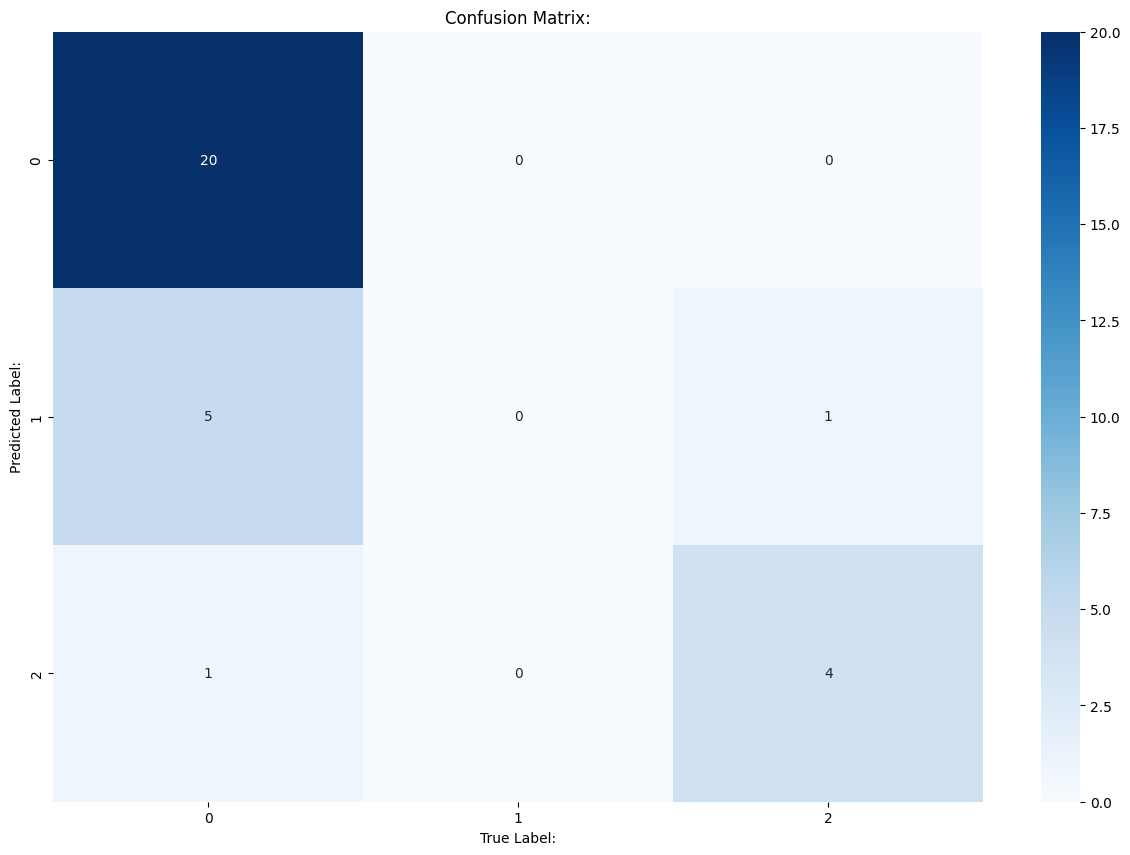

In [ ]:
confusion_mtx = confusion_matrix(y_true, y_pred_class)
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(confusion_mtx, annot =True, fmt='d', ax=ax, cmap = 'Blues')
ax.set_xlabel('True Label:')
ax.set_ylabel('Predicted Label:')
ax.set_title('Confusion Matrix:');